In [1]:
import os

# to avoid the following error when using MPS (GPU in ARM architecture)):
# NotImplementedError: The operator 'aten::scatter_reduce.two_out'
# is not currently implemented for the MPS device. If you want
# this op to be added in priority during the prototype phase of
# this feature, please comment on
# https://github.com/pytorch/pytorch/issues/77764.
# As a temporary fix, you can set the environment variable
# `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as
# a fallback for this op.
# WARNING: this will be slower than running natively on MPS.
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"  # before importing torch

print(os.cpu_count())


8


\# TODO

- <s>BatchNormalization?</s>
- ハイパーパラメータチューニング (optuna?)
- <s>モデルの解釈 (tanhやpoolingについて)</s>
  - tanh: 活性化関数
  - pooling: すべての原子の情報を統合する。原子数が異なるためそれらを揃える役割も。
- <s>dropoutの導入？←過学習対策</s>
- autumentation?
- モデルの途中保存 (エポック毎?)
- エッジの重みも学習する (`nn.Parameter`?)
- early-stopping
- max-poolingの検討
- 転移学習 (fine-tuning and feature-extraction)
- [GIN層](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GINConv.html#torch_geometric.nn.conv.GINConv)を試してみる

In [2]:
import numpy as np
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import torch
import torch_geometric
import torch_geometric.nn
import torch_geometric.data
import torch_geometric.loader

from torch_utils.data import GraphDataset
from torch_utils.model import GCN, GNN
from torch_utils.torch_utils import (
    fit,
    evaluate_history,
    torch_seed,
    EarlyStopping,
)
from torch_utils.utils import yyplot, check_tqdm


In [3]:
torch.__version__


'2.1.0'

In [4]:
torch_geometric.__version__


'2.4.0'

In [5]:
rdkit.__version__


'2023.09.1'

In [6]:
seed = 334
batch_size = 256

torch_seed(seed)


In [7]:
# df_raw = pd.read_csv("./data/curated-solubility-dataset.csv", index_col=0)
df_raw = pd.read_csv("./data/logSdataset1290.csv", index_col=0)
# 計算時間短縮
# df_raw = df_raw.iloc[:1000]
print(df_raw.shape)
df_raw.head()


(1290, 197)


,logS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
CC(N)=O,1.58,59.068,54.028,59.037114,24,0,0.213790,-0.369921,0.369921,0.213790,...,0,0,0,0,0,0,0,0,0,0
CNN,1.34,46.073,40.025,46.053098,20,0,-0.001725,-0.271722,0.271722,0.001725,...,0,0,0,0,0,0,0,0,0,0
CC(=O)O,1.22,60.052,56.020,60.021129,24,0,0.299685,-0.481433,0.481433,0.299685,...,0,0,0,0,0,0,0,0,0,0
C1CCNC1,1.15,71.123,62.051,71.073499,30,0,-0.004845,-0.316731,0.316731,0.004845,...,0,0,0,0,0,0,0,0,0,0
NC(=O)NO,1.12,76.055,72.023,76.027277,30,0,0.335391,-0.349891,0.349891,0.335391,...,0,0,0,0,0,0,0,0,0,1


In [8]:
# smiles = df_raw["SMILES"]
# y = df_raw["Solubility"]
smiles = df_raw.index
y = df_raw["logS"]


In [9]:
# scaling
y_mean = y.mean()
y_std = y.std(ddof=1)


In [10]:
smiles = smiles.tolist()
y = torch.Tensor(((y - y_mean) / y_std).tolist()).view(-1, 1)


In [11]:
mols = map(Chem.MolFromSmiles, smiles)


In [12]:
dataset = GraphDataset(mols, y, use_edges=True, n_jobs=-1, ipynb=True)
dataset


  0%|          | 0/1290 [00:00<?, ?it/s]

GraphDataset(size=1290)

In [13]:
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
dataloader = torch_geometric.loader.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)
# the following is deprecated
# dataloader = torch_geometric.data.DataLoader(
#     dataset, batch_size=batch_size, shuffle=True
# )
dataloader


In [14]:
dataset_train, dataset_test = train_test_split(
    dataset, test_size=0.2, random_state=seed
)
dataset_train, dataset_val = train_test_split(
    dataset_train, test_size=0.1, random_state=seed
)
print(len(dataset_train), len(dataset_val), len(dataset_test))


928 104 258


In [15]:
dataloader_train = torch_geometric.loader.DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True
)
dataloader_val = torch_geometric.loader.DataLoader(
    dataset_val, batch_size=batch_size, shuffle=False
)
dataloader_test = torch_geometric.loader.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False
)


In [16]:
data = dataset_train[0]
num_features = data.x.shape[1]


In [17]:
# model = GCN(in_channels=num_features, embedding_size=64)
model = GNN(in_channels=num_features, embedding_size=64)
print(model)


GNN(
  (initial_conv): NNConv(30, 64, aggr=add, nn=Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=1920, bias=True)
  ))
  (batch_norm0): BatchNorm(64)
  (conv1): NNConv(64, 64, aggr=add, nn=Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=4096, bias=True)
  ))
  (batch_norm1): BatchNorm(64)
  (conv2): NNConv(64, 64, aggr=add, nn=Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=4096, bias=True)
  ))
  (conv3): NNConv(64, 64, aggr=add, nn=Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=4096, bias=True)
  ))
  (dropout): Dropout(p=0.05, inplace=False)
  (relu): 

In [18]:
# Need 'tabulate' package
print(torch_geometric.nn.summary(model, data))


+----------------------------+---------------+----------------+----------+
| Layer                      | Input Shape   | Output Shape   | #Param   |
|----------------------------+---------------+----------------+----------|
| GNN                        | [14, 14]      | [1, 1]         | 941,441  |
| ├─(initial_conv)NNConv     |               | [14, 64]       | 127,552  |
| ├─(batch_norm0)BatchNorm   | [14, 64]      | [14, 64]       | 128      |
| │    └─(module)BatchNorm1d | [14, 64]      | [14, 64]       | 128      |
| ├─(conv1)NNConv            |               | [14, 64]       | 271,168  |
| ├─(batch_norm1)BatchNorm   | [14, 64]      | [14, 64]       | 128      |
| │    └─(module)BatchNorm1d | [14, 64]      | [14, 64]       | 128      |
| ├─(conv2)NNConv            |               | [14, 64]       | 271,168  |
| ├─(conv3)NNConv            |               | [14, 64]       | 271,168  |
| ├─(dropout)Dropout         | [14, 64]      | [14, 64]       | --       |
| ├─(relu)LeakyReLU      

In [19]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device


device(type='mps')

In [20]:
early_stopping = EarlyStopping(patience=5, verbose=True)

history = fit(
    model.to(device),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.002),
    criterion=torch.nn.MSELoss(),
    train_loader=dataloader_train,
    val_loader=dataloader_val,
    num_epochs=10,
    # num_epochs=100,
    device=device,
    early_stopping=early_stopping,
    ipynb=True,
)


  0%|          | 0/4 [00:00<?, ?it/s]

/Users/yu9824/miniforge3/envs/torch39/lib/python3.9/site-packages/torch_geometric/utils/scatter.py:94: UserWarning: The operator 'aten::scatter_reduce.two_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1695391825142/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  return src.new_zeros(size).scatter_reduce_(


Epoch [1/10], loss: 41.98324 val_loss: 2.40592, 
Validation loss decreased (inf --> 2.405922).  Saving model ...


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/10], loss: 2.13913 val_loss: 1.24769, 
Validation loss decreased (2.405922 --> 1.247690).  Saving model ...


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/10], loss: 1.09772 val_loss: 1.06970, 
Validation loss decreased (1.247690 --> 1.069697).  Saving model ...


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.76886 val_loss: 1.10139, 
EarlyStopping counter: 1 out of 5


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.73623 val_loss: 1.02442, 
Validation loss decreased (1.069697 --> 1.024418).  Saving model ...


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.58426 val_loss: 0.75820, 
Validation loss decreased (1.024418 --> 0.758205).  Saving model ...


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.55003 val_loss: 0.67901, 
Validation loss decreased (0.758205 --> 0.679009).  Saving model ...


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.46437 val_loss: 0.66015, 
Validation loss decreased (0.679009 --> 0.660154).  Saving model ...


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.43908 val_loss: 0.57474, 
Validation loss decreased (0.660154 --> 0.574741).  Saving model ...


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.38421 val_loss: 0.52425, 
Validation loss decreased (0.574741 --> 0.524254).  Saving model ...


初期状態: 損失: 2.40592
最終状態: 損失: 0.52425


<Axes: title={'center': 'Training and validation loss history'}, xlabel='epoch', ylabel='loss'>

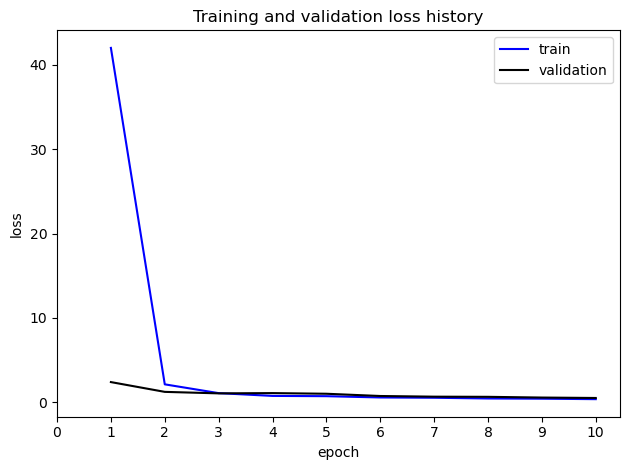

In [21]:
evaluate_history(history)


In [22]:
model.training


False

In [23]:
_tmp_y = []
_tmp_y_pred = []
for _batchdata_test in dataloader_test:
    _tmp_y.append(_batchdata_test.y)
    _tmp_y_pred.append(model(_batchdata_test.to(device)))


In [24]:
y_test_scaled = torch.cat(_tmp_y, dim=0)
y_pred_on_test_scaled = torch.cat(_tmp_y_pred, dim=0)


In [25]:
y_test = y_test_scaled * y_std + y_mean
y_pred_on_test = y_pred_on_test_scaled * y_std + y_mean


In [26]:
_tmp_y = []
_tmp_y_pred = []
for _batchdata_val in dataloader_val:
    _tmp_y.append(_batchdata_val.y)
    _tmp_y_pred.append(model(_batchdata_val.to(device)))


In [27]:
y_val_scaled = torch.cat(_tmp_y, dim=0)
y_pred_on_val_scaled = torch.cat(_tmp_y_pred, dim=0)


In [28]:
y_val = y_val_scaled * y_std + y_mean
y_pred_on_val = y_pred_on_val_scaled * y_std + y_mean


In [29]:
_tmp_y = []
_tmp_y_pred = []
for _batchdata_train in dataloader_train:
    _tmp_y.append(_batchdata_train.y)
    _tmp_y_pred.append(model(_batchdata_train.to(device)))


In [30]:
y_train_scaled = torch.cat(_tmp_y, dim=0)
y_pred_on_train_scaled = torch.cat(_tmp_y_pred, dim=0)


In [31]:
y_train = y_train_scaled * y_std + y_mean
y_pred_on_train = y_pred_on_train_scaled * y_std + y_mean


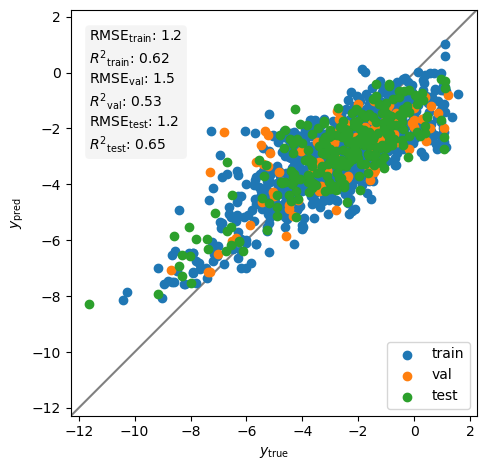

In [32]:
ax = yyplot(
    y_train.cpu().detach().numpy(),
    y_pred_on_train.cpu().detach().numpy(),
    y_val.cpu().detach().numpy(),
    y_pred_on_val.cpu().detach().numpy(),
    y_test.cpu().detach().numpy(),
    y_pred_on_test.cpu().detach().numpy(),
)
ax.figure.tight_layout()


In [33]:
# rdkit記述子を使ってRandomForestで予測した値と比較

dict_feat = dict()
for desc_name, desc_func in check_tqdm(Descriptors.descList, ipynb=True):
    dict_feat[desc_name] = [
        desc_func(Chem.MolFromSmiles(smi)) for smi in smiles
    ]
X = pd.DataFrame.from_dict(dict_feat)
X.head()


  0%|          | 0/211 [00:00<?, ?it/s]

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,9.222222,9.222222,0.333333,-0.333333,0.401031,6.25,59.068,54.028,59.037114,24,...,0,0,0,0,0,0,0,0,0,0
1,4.597222,4.597222,1.652778,1.652778,0.273315,6.00,46.073,40.025,46.053098,20,...,0,0,0,0,0,0,0,0,0,0
2,9.000000,9.000000,0.833333,-0.833333,0.429883,6.25,60.052,56.020,60.021129,24,...,0,0,0,0,0,0,0,0,0,0
3,3.222222,3.222222,1.250000,1.250000,0.434794,24.00,71.123,62.051,71.073499,30,...,0,0,0,0,0,0,0,0,0,0
4,9.229167,9.229167,0.939815,-0.939815,0.256644,6.60,76.055,72.023,76.027277,30,...,0,0,0,0,0,0,0,0,0,1


In [34]:
X = X.loc[:, ~(X.isnull().any() | np.isinf(X).any())].astype(np.float32)
print(X.shape)
X.head()


(1290, 210)


,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,9.222222,9.222222,0.333333,-0.333333,0.401031,6.25,59.068001,54.028000,59.037113,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.597222,4.597222,1.652778,1.652778,0.273315,6.00,46.073002,40.025002,46.053097,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.000000,9.000000,0.833333,-0.833333,0.429883,6.25,60.051998,56.020000,60.021130,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.222222,3.222222,1.250000,1.250000,0.434794,24.00,71.123001,62.050999,71.073502,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.229167,9.229167,0.939815,-0.939815,0.256644,6.60,76.055000,72.023003,76.027275,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


/Users/yu9824/miniforge3/envs/torch39/lib/python3.9/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


<Axes: xlabel='$y_\\mathrm{true}$', ylabel='$y_\\mathrm{pred}$'>

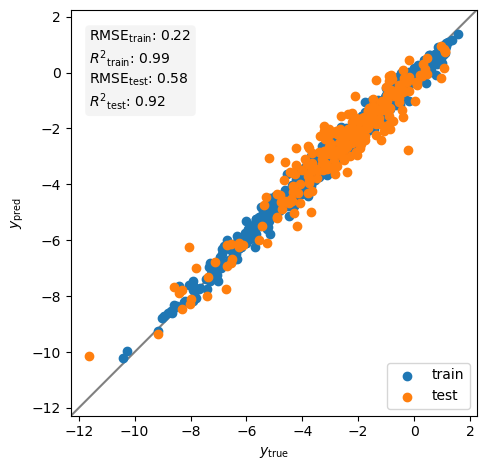

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, np.array(y) * y_std + y_mean, test_size=0.2, random_state=seed
)
rf = RandomForestRegressor(random_state=seed, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_on_test = rf.predict(X_test)
y_pred_on_train = rf.predict(X_train)
yyplot(y_train, y_pred_on_train, y_test, y_pred_on_test)
